# Conveyance Curve

In ICM, the conveyance curve needs to be reviewed to avoid this [particular problem](http://help.floodmodeller.com/floodmodeller/Technical_Reference/1D_Nodes_Reference/Rivers/Conveyance_and_Cross-Section_Property_Display.htm).

```
"A common cause of instabilities in a model is a decrease in conveyance with increasing stage, 
therefore the conveyance plotting tool gives the modeller a quick reference to check that conveyance 
increases monotonically and smoothly with stage. A decrease in conveyance as the water level goes out-of-bank 
may be rectified by adding a panel marker at bank level."
```

In this notebook, I'll go through the steps to see how panel markers are impacting the conveyance curve.

# Channel Conveyance

Using manning's equation the discharge at a given cross section can be calculated using the cross section geometry, manning's n and the slope of channel.



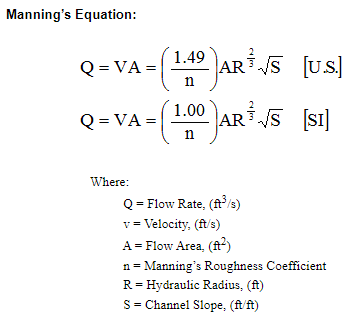

# Panel
In general, as water rises in the cross section, its area increases, and the wetted perimeter increases. In general, the area increases faster than the increases of the wetted perimeter so that the conveyance (Q) keeps increasing.

However, when the water started to flow over the main channel into the much shallower overbank areas, or some flat and small depressed areas of the cross section, the wetted perimeter increases much faster and as a result the Q decreases.
In some cases, this is what happened in the real world. However, in most of the cases, it is the result of an oversimplification of our conveyance calculation. When water flows overbank, it shouldn't decrease most of the conveyance within the main channel, however since we ignored the detailed geometry in the calculation, we wouldn’t be able to correct it.
To overcome this limitation, panels are added to divide cross section into sections, and conveyance is calculated for each panel, that way when water overflows to the overbank, it doesn’t impact the conveyance in the main channel.



For example, HECRAS calculates the cross section parameters using the following method,

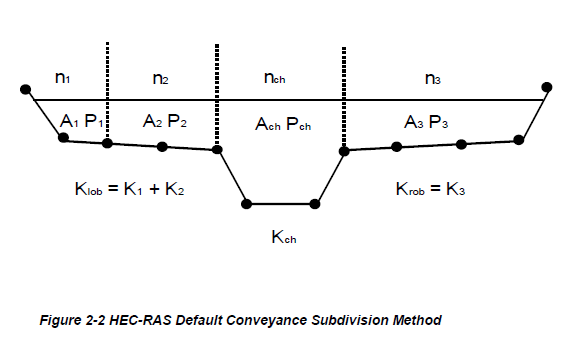

# Examples of Q decreases as flow depth increases

A few interesting examples showing when water is deeper, the flow might be lower.

For partially full pipe flow, the max flow occurs before the pipe is full. As explained in [here](https://en.wikipedia.org/wiki/Flow_in_partially_full_conduits).


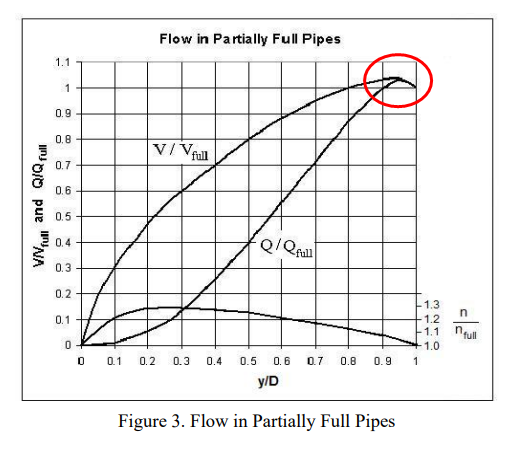

According to [this study](http://www.river-conveyance.net/1_CES_UserGuide.pdf), conveyance can jump or decrease as water flows overbank in real world.

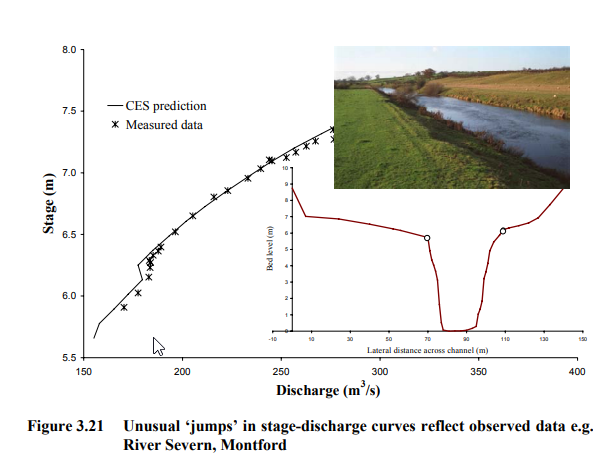

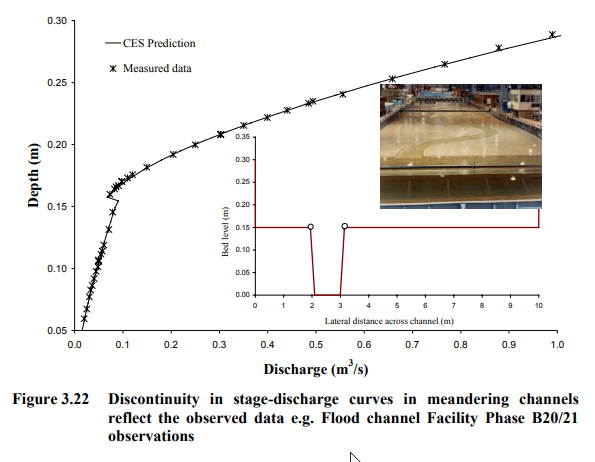

# ICM Conveyance Example

As shown below, I built a simple river reach with this cross section. Any time I added a flat area, the conveyance calculation will have some issues calculating the results.

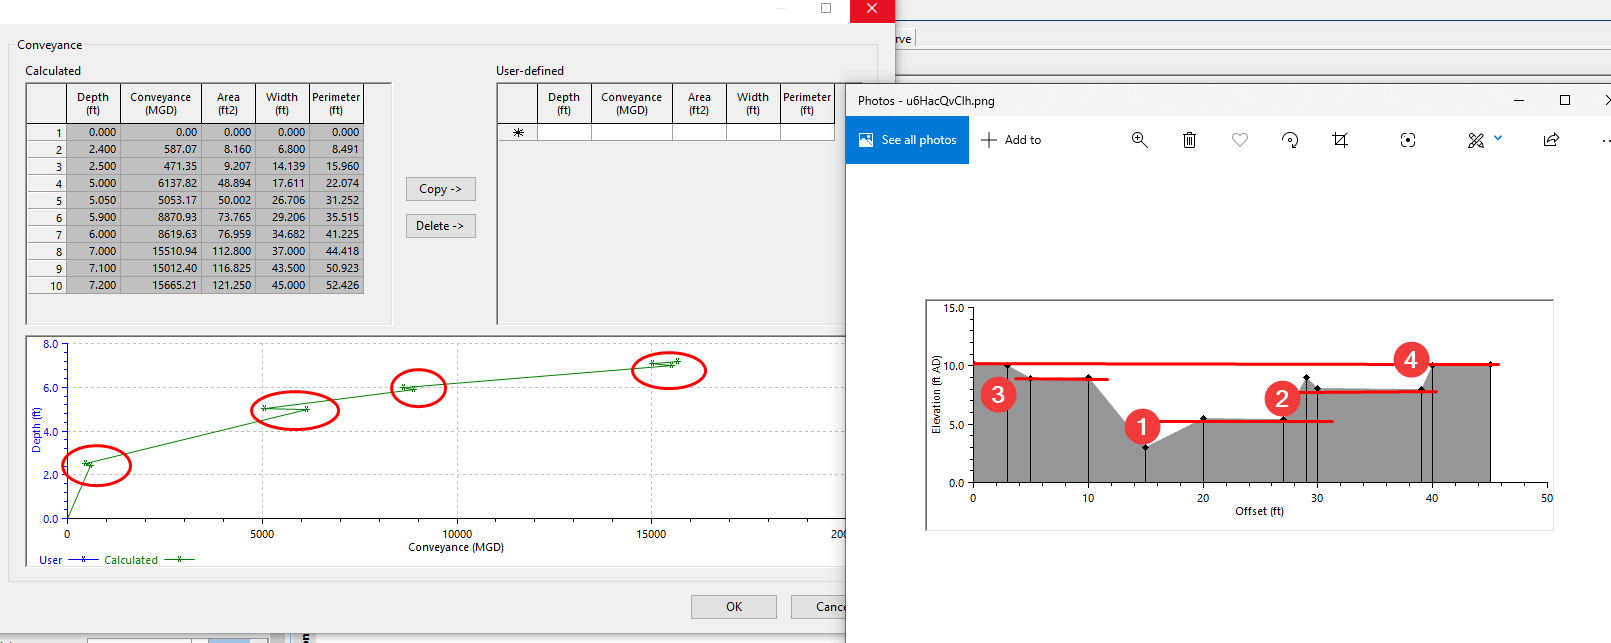

# A better way to check conveyance

As a fun experiment, I built this interactive cross section vs conveyance figure below. You can interactively check both charts at the same time, the depth field is in sync.

Below is jut a screenshot, scroll down for the interactive charts.

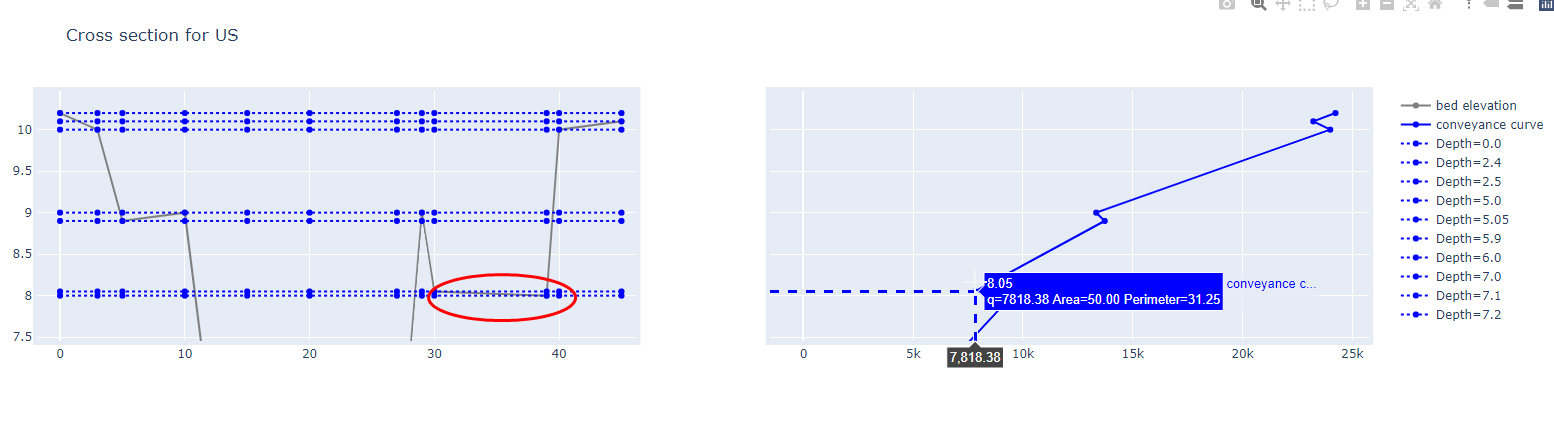

In [1]:
import pandas as pd
import csv
import os
import plotly.graph_objects as go
from plotly.subplots import make_subplots


def plot_xs(conveyance_df, xs_df, invert, level_fld='level', z_fld = 'z', offset_fld='offset'):
    df_xs = xs_df.copy()
    df_cv = conveyance_df.copy()
    df_cv['z'] = df_cv['Depth (ft)'] + invert
    fig = make_subplots(rows=1, cols=2, 
                        shared_yaxes=True, 
                        vertical_spacing=0.01
                       )
#     ax = df_xs.plot(x=offset_fld, y=z_fld, linewidth=3, alpha=0.5, color='grey', figsize=(20,10), label='bed elevation')
    fig.add_trace(go.Scatter(
        x = df_xs[offset_fld],
        y = df_xs[z_fld],
        name = 'bed elevation',
        mode='lines+markers',
        line=dict(color='grey')
    ), row=1, col=1 )
    
    hovertext = []
    for idx, r in df_cv.iterrows():
        hovertext.append('q=%.2f Area=%.2f Perimeter=%.2f' % (r['no_panel'], r['Area (ft2)'], r['Perimeter (ft)'])) 
    fig.add_trace(go.Scatter(
        x = df_cv['no_panel'],
        y = df_cv['z'],
        name = 'conveyance curve',
        mode='lines+markers',
        hovertext = hovertext,
        line=dict(color='blue')
    ), row=1, col=2 )
        
    for idx, r in conveyance_df.iterrows():
        level = r['Depth (ft)'] + invert
        icm_area = r['Area (ft2)']
        df_xs['level'] = level
        fig.add_trace(go.Scatter(
        x = df_xs[offset_fld],
        y = df_xs['level'],
        name = 'Depth=%s' % r['Depth (ft)'],
        line=dict(color='blue', dash='dot')
    ), row=1, col=1)
#         df_xs.plot(x=offset_fld, y='level', style='--', color='blue', alpha=0.2, label='Depth=%s' % r['Depth (ft)'], ax=ax)
    return fig
        
        

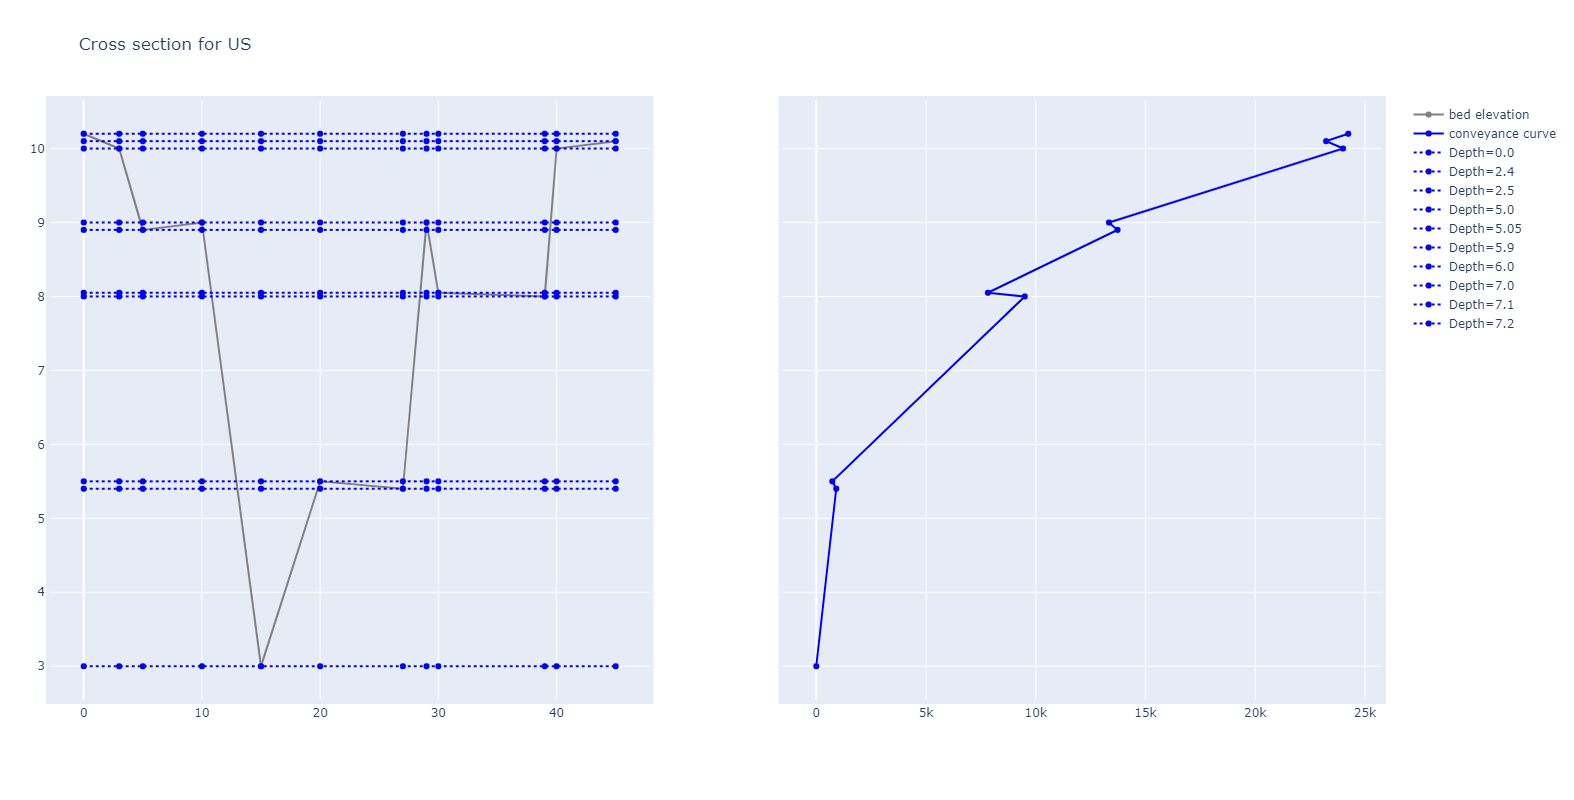

In [2]:
ws = r'C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\references\river\conveyance\data'
conveyance_curve = os.path.join(ws, 'conveyance_curve.csv')
invert = 3
conveyance_csv = os.path.join(ws, 'conveyance_curve.csv')
df = pd.read_csv(conveyance_csv)

xs_csv = os.path.join(ws, 'cross section.csv')
df_xs = pd.read_csv(xs_csv)
fig = plot_xs(conveyance_df=df, xs_df=df_xs, invert=invert, level_fld='level', z_fld = 'z', offset_fld='offset')

fig.update_layout(
    title='Cross section for US',
    autosize=True,
    width=1200,
    height=800,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
    paper_bgcolor="White",
)

# Adding Panels to fix the issues



As shown in the figure below, I basically set the panel markers at the overflow points. And you can find the scenarios in the ICM trasportable file: **GitHub\SewerAnalysis\references\river\conveyance\data\conveyance_curve.icmt**

- Panel 4: by adding a panel marker at point 4, I divided the cross section in two panels
- Panel 6: then add panel marker at point 6, I further divide the cross section into 3 panels
- similarly I keep dividing at Panel 9 and 11


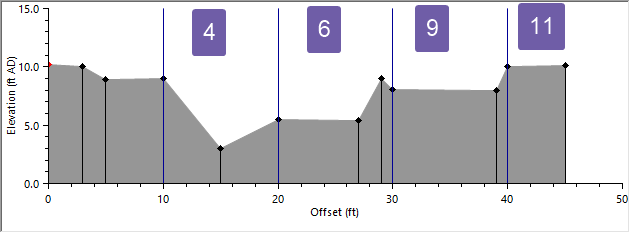

After pasting the conveyance results into the same csv file, I can plot the changes after adding the panel markers using the script below. The base scenario is the no panel scenario. 

The figure below clearly shows how each panel maker fixes each problem area.

In [3]:
import pandas as pd
import csv
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os

def plot_conveyance_csv(csv_path, fields):
    df = pd.read_csv(csv_path)
    fig = go.Figure()
    for fld in fields:
        fig.add_trace(go.Scatter(
                x = df[fld],
                y = df['Depth (ft)'],
                name = fld,
                mode='lines+markers'
            ))
    return fig, df

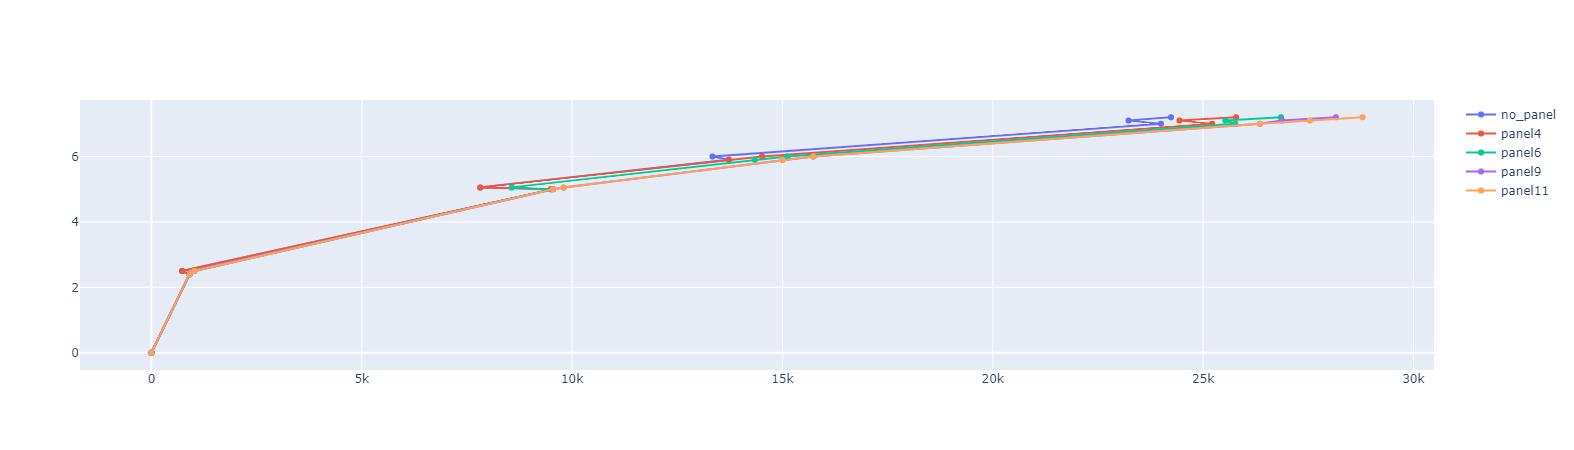

In [4]:

fields = ['no_panel', 'panel4', 'panel6', 'panel9', 'panel11']
fig, df = plot_conveyance_csv(conveyance_curve, fields)
fig

In [11]:
df

Depth (ft)  no_panel  Area (ft2)  Width (ft)  Perimeter (ft)    panel4  \
0        0.00      0.00       0.000       0.000           0.000      0.00   
1        2.40    908.32       8.160       6.800           8.491    908.32   
2        2.50    729.28       9.207      14.139          15.960    729.28   
3        5.00   9496.58      48.894      17.611          22.074   9496.58   
4        5.05   7818.38      50.002      26.706          31.252   7818.38   
5        5.90  13725.31      73.765      29.206          35.515  13725.31   
6        6.00  13336.50      76.959      34.682          41.225  14515.32   
7        7.00  23998.90     112.800      37.000          44.418  25215.48   
8        7.10  23227.54     116.825      43.500          50.923  24437.99   
9        7.20  24237.59     121.250      45.000          52.426  25786.24   

     panel6    panel9   panel11  panel_random  panel_all  
0      0.00      0.00      0.00          0.00       0.00  
1    908.32    908.32    908.32        920.28     920.28  
2   1018.23   1018.23   1018.23        744.40    1031.57  
3   9546.64   9546.64   9546.64       9669.88   10397.12  
4   8562.69   9798.88   9798.88       9931.40   10683.80  
5  14339.17  14999.55  14999.55      15575.60   16908.16  
6  15119.21  15734.46  15734.46      15664.77   17783.16  
7  25766.92  26353.22  26353.22      26733.11   28989.54  
8  25530.37  26872.87  27539.30      28008.03   30308.50  
9  26851.56  28159.12  28791.45      29344.34   31680.92

# Sensitivity Analysis

As I noticed, there is no obvious way to place the panel markers, for cross sections with hundreds of point, I bet everytime I'll come up with a slightly different position for the markers. And that's probably why ICM didn't automate the insertion of panel markers. 

So I think it is important to run some sensitivity analysis to see how big an impact this cause.

I created two more scenarios,
- add panel markers at all points: panel all scenario

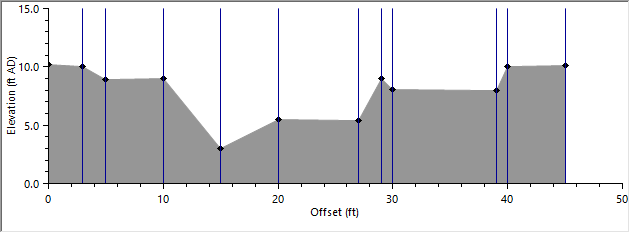

- randomly add panel markers: panel random scenario

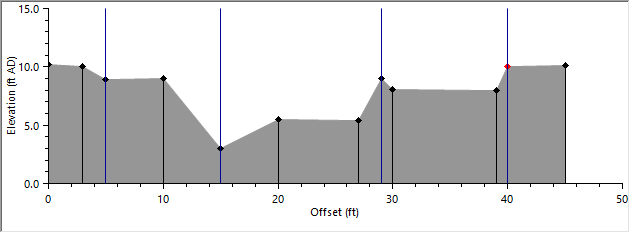

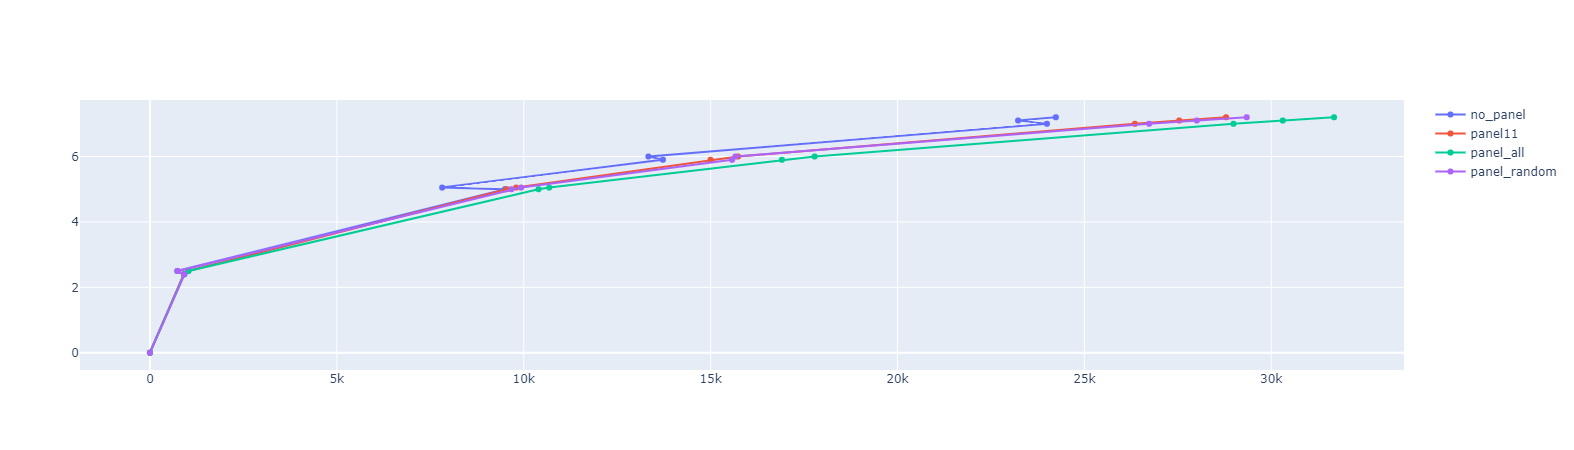

In [14]:
fields = ['no_panel', 'panel11', 'panel_all', 'panel_random']
fig, df = plot_conveyance_csv(conveyance_curve, fields)
fig

# Conclusion
As shown above, apparently how the panels are divided will impact the conveyance curve. The scenario with panel markers at all points resulted much lower conveyance, and the randomly placed markers also showed noticable differnce from our best estimate.

Next time, if I am not sure how I should add my panel markers I'll most likely perform a similar analysis to make sure I understand how much an impact my panel markers decisions will make on the conveyance curve.

# Calculating Cross Section Geometry in Python

Just for fun, I would like to see how hard it is to calculate area and wetted perimeter uisng python.


I saved the cross section to the file : cross section.csv

In [6]:
import numpy as np
f = os.path.join(ws, 'cross section.csv')
df_xs = pd.read_csv(f)

In [7]:
df_xs

offset  X coordinate (ft)  Y coordinate (ft)      z  \
0        0                 45               1000  10.20   
1        3                 42               1000  10.00   
2        5                 40               1000   8.90   
3       10                 35               1000   9.00   
4       15                 30               1000   3.00   
5       20                 25               1000   5.50   
6       27                 18               1000   5.40   
7       29                 16               1000   9.00   
8       30                 15               1000   8.05   
9       39                  6               1000   8.00   
10      40                  5               1000  10.00   
11      45                  0               1000  10.10   

    Roughness Manning's n  New panel  
0                   0.013        NaN  
1                   0.013        NaN  
2                   0.013        NaN  
3                   0.013        NaN  
4                   0.013        NaN  
5                   0.013        NaN  
6                   0.013        0.0  
7                   0.013        NaN  
8                   0.013        NaN  
9                   0.013        NaN  
10                  0.013        NaN  
11                  0.013        NaN

## Sampling the Cross Section

To use the area function np.trapz, I'll need to sample the profile at regular intervals. I basically divided the profile into 1000 points. The green dots are the orignal data, and the dense X are the interpolated points.

Note that ICM uses depth not elevation in the reported conveyance table. Since the lowest point of the cross section is 3ft, to turn depth into elevation 3 needs to be added to depth.

Here is how I calculate the area,
- interpolate the xs to 1000 points, so that I can calculate the area for each slice, and with this many point I don't need to calculate where the water leve line intersecs the profile
- add the level to each profile point, if level > z, then keep the point
- with only lines below the level line, I can calculate the area under the level line and the profile
- the difference is the area

Wetted perimeter is a little tricky, here is my hack
- after filtering out all points above the level line, I got the points below the level
- the problem is that if there are a few separated areas under the water level, I need to remove the lines that are above the level line
- the trick is that I check the distance between every two points, if the x2-x1 is greater than the spacing, it means it is a jump from one area to another, and I should ignore it.


My hack seems to work fine for this example. I am pretty sure my hack won't work for more complicated situations.

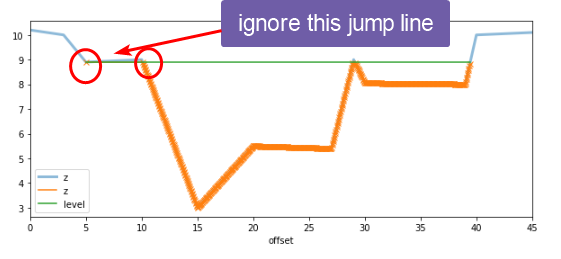

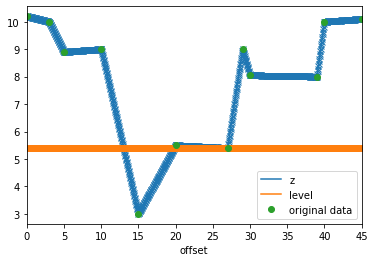

In [59]:
offset = np.linspace(0, 45, 1000)
z = np.interp(offset, df_xs['offset'], df_xs['z'])

df2 = pd.DataFrame({'offset': offset, 'z': z})
df2['level'] = [5.4]*len(offset)
ax = df2.plot(x='offset', y='z', style='x-')
df2.plot(x='offset', y='level', style='x-', ax=ax)
df_xs.plot(x='offset', y='z', style='o', ax=ax, label='original data')

In [60]:
def line_length(x, y, ignore=None):
    # ignore is used to filter out lines connecting two far apart dot.
    # since I am using regular spacing, if they distance between two dots is larger than the spacing, it means there is a disconnect.
    npts = len(x)
    # need to make sure it is a line with at least 2 points
    if npts < 2:
        return 0
    
    arc = np.sqrt((x[1] - x[0])**2 + (y[1] - y[0])**2)
    if ignore:
        if arc > ignore*1.1:
            arc = 0
            
    for k in range(1, npts):
        if ignore:
            if x[k] - x[k-1] > ignore*1.1:
                pass
            else:
                arc = arc + np.sqrt((x[k] - x[k-1])**2 + (y[k] - y[k-1])**2)
        else:
            arc = arc + np.sqrt((x[k] - x[k-1])**2 + (y[k] - y[k-1])**2)

    return arc

def get_area(xs_csv, level, level_fld='level', z_fld = 'z', offset_fld='offset'):
    df_xs = pd.read_csv(xs_csv)
    
    # interpolate profile using regular spacing so that I can calculate the area
    offset = np.linspace(min(df_xs[offset_fld].values), max(df_xs[offset_fld].values), 1000)
    z = np.interp(offset, df_xs[offset_fld], df_xs[z_fld])

    df2 = pd.DataFrame({'offset': offset, 'z': z})
    df2[level_fld] = [level]*len(offset)
    # get the dx for the x axis
    dx = df2[offset_fld].diff().values[-1]
    # find the area below the water level
    area = df2.loc[df2[level_fld] >= df2[z_fld]]
    # get the area under level line
    a1 = np.trapz(area[level_fld], x=None, dx=dx, axis=-1)
    # get the area under the cross section
    a2 = np.trapz(area[z_fld], x=None, dx=dx, axis=-1)
    a3 = a1 - a2
    l = line_length(area[offset_fld].values, area[z_fld].values, dx)
    
    
    
    ax = df_xs.plot(x=offset_fld, y=z_fld, linewidth=3, alpha=0.5, figsize=(10,4))
    area.plot(x=offset_fld, y=z_fld,  style='x-',ax=ax)
    area.plot(x=offset_fld, y=level_fld, ax=ax)
    plt.title(level)
    return a3, l

Depth (ft)  Area (ft2)  python_area  Perimeter (ft)  python_perimeter
0        0.00       0.000     0.000000           0.000          0.000000
1        2.40       8.160     8.159646           8.491          8.434315
2        2.50       9.207     9.205694          15.960         15.875656
3        5.00      48.894    48.893301          22.074         21.987692
4        5.05      50.002    50.001258          31.252         31.163352
5        5.90      73.765    73.763391          35.515         35.303694
6        6.00      76.959    76.957126          41.225         41.103031
7        7.00     112.800   112.799590          44.418         44.368061
8        7.10     116.825   116.824764          50.923         50.905390
9        7.20     121.250   121.249797          52.426         52.440321

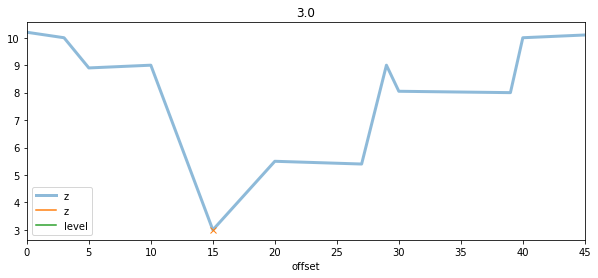

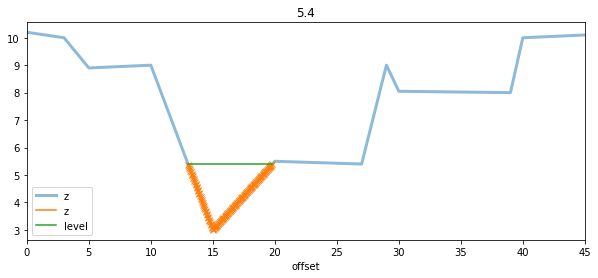

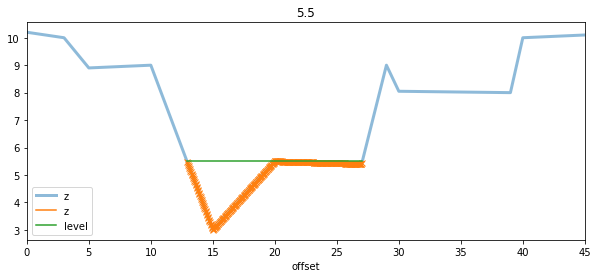

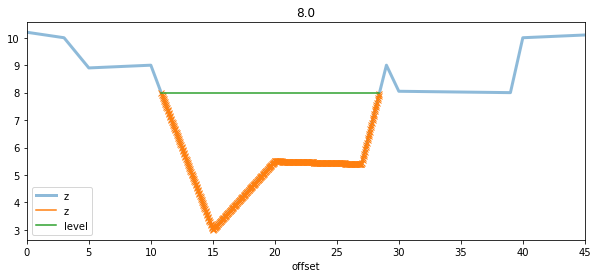

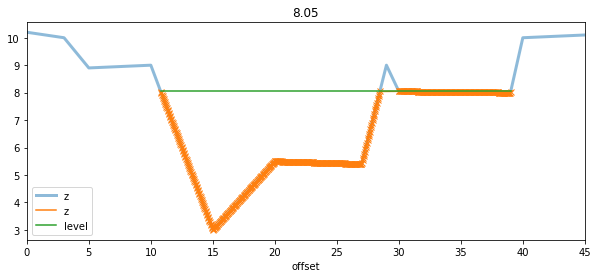

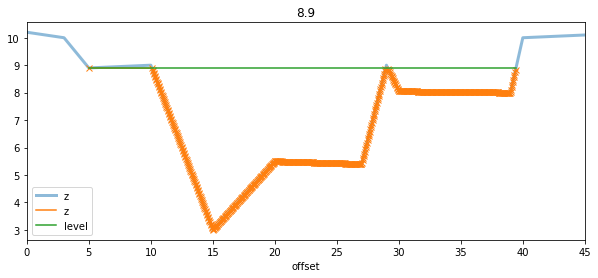

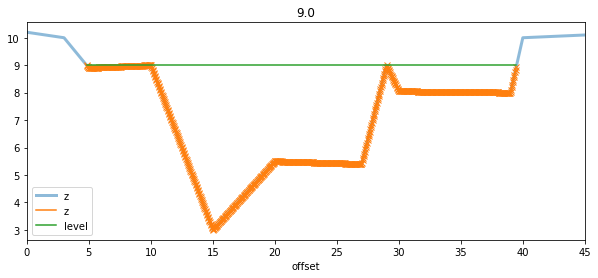

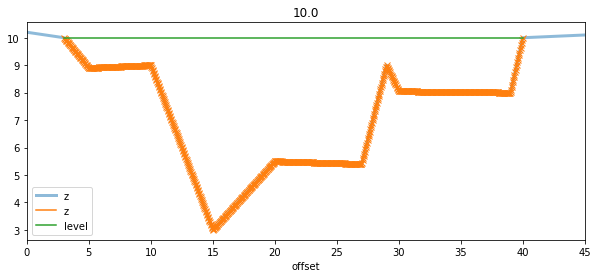

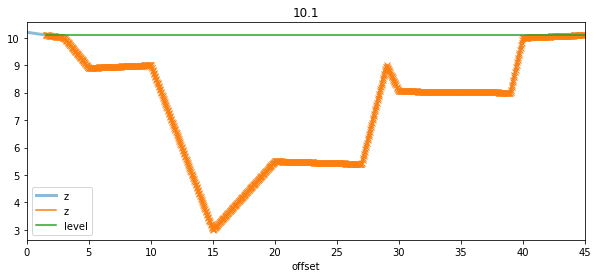

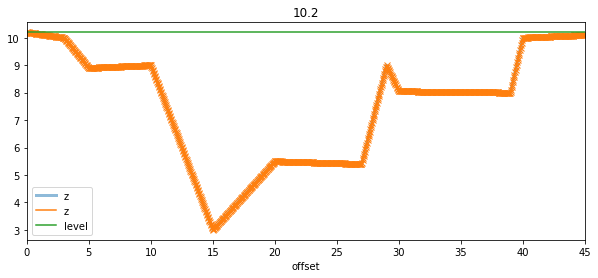

In [61]:
df['python_area'] = 0
df['python_perimeter'] = 0
for idx, r in df.iterrows():
    level = r['Depth (ft)']
    icm_area = r['Area (ft2)']
    a, l = get_area(xs_csv=f, level=level+3, level_fld='level', z_fld = 'z', offset_fld='offset')
    df.loc[idx, 'python_area'] = a
    df.loc[idx, 'python_perimeter'] = l
    
    
    
df.loc[:, ['Depth (ft)', 'Area (ft2)', 'python_area', 'Perimeter (ft)', 'python_perimeter']]
    

As shown above, my calculation is pretty close to ICM reported values. When I have more time, I might do a few calculation of the panels.